<a href="https://colab.research.google.com/github/yashika-git/Deep_Learning/blob/main/RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Training a simple RNN

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

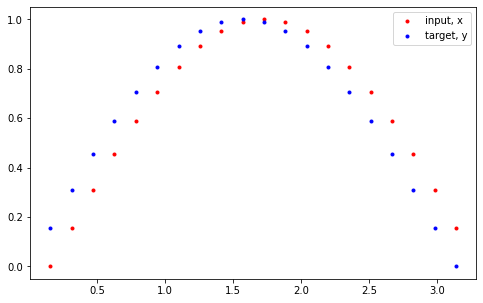

In [2]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data points using sine function
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [ ]:
# Defining RNN
# RNN layer parameters are:
#input_size - the size of the input
#hidden_dim - the number of features in the RNN output and in the hidden state
#n_layers - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
#batch_first - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim

        # defining an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # changing shape of output to (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden